In [19]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/var/folders/0m/66g0_plj0kx3gn328ysf7pb80000gn/T/ipykernel_30645/3317796757.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


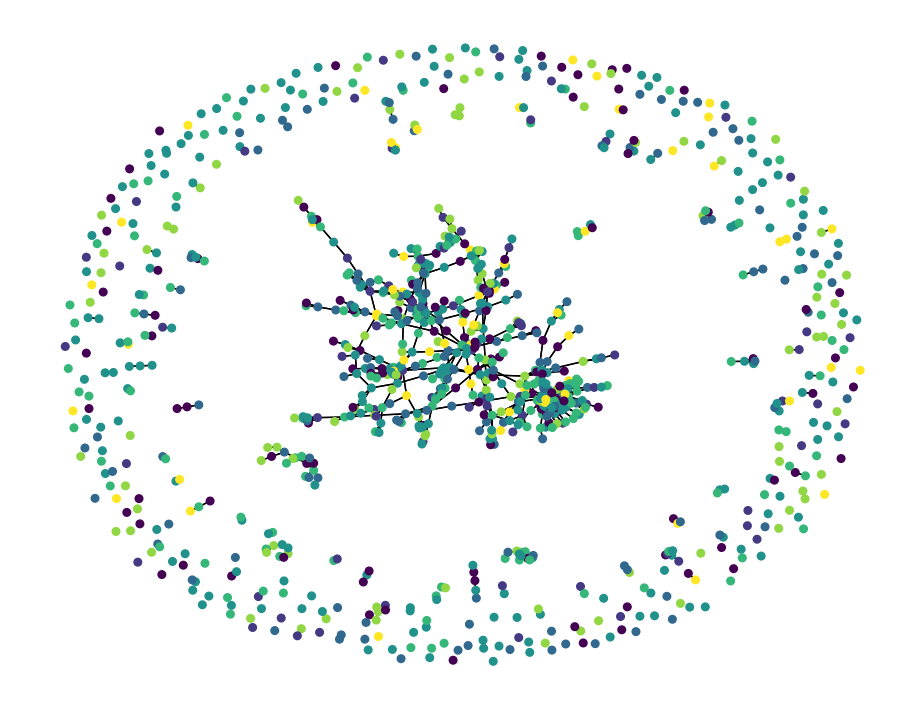

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [26]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
print(graph)
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)
print(graph)

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

In [31]:
graph.train_mask, graph.val_mask

(tensor([False,  True, False,  ...,  True,  True,  True]),
 tensor([ True, False,  True,  ..., False, False, False]))

In [30]:
graph.mask

AttributeError: 'GlobalStorage' object has no attribute 'mask'

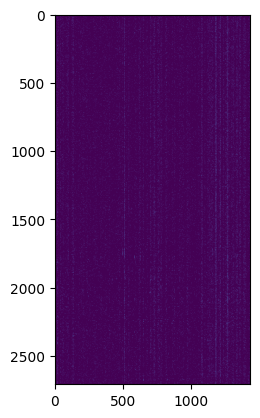

In [28]:
plt.imshow(graph.x)

In [24]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [22]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc
  
  
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.837, Val Acc: 0.642
Epoch: 020, Train Loss: 0.077, Val Acc: 0.720
Epoch: 030, Train Loss: 0.016, Val Acc: 0.745
Epoch: 040, Train Loss: 0.012, Val Acc: 0.734
Epoch: 050, Train Loss: 0.012, Val Acc: 0.731
Epoch: 060, Train Loss: 0.009, Val Acc: 0.712
Epoch: 070, Train Loss: 0.008, Val Acc: 0.705
Epoch: 080, Train Loss: 0.007, Val Acc: 0.720
Epoch: 090, Train Loss: 0.007, Val Acc: 0.723
Epoch: 100, Train Loss: 0.006, Val Acc: 0.716
Epoch: 110, Train Loss: 0.006, Val Acc: 0.716
Epoch: 120, Train Loss: 0.006, Val Acc: 0.712
Epoch: 130, Train Loss: 0.006, Val Acc: 0.712
Epoch: 140, Train Loss: 0.006, Val Acc: 0.716
Epoch: 150, Train Loss: 0.006, Val Acc: 0.708
Test Acc: 0.723


In [23]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 1.064, Val Acc: 0.753
Epoch: 020, Train Loss: 0.437, Val Acc: 0.867
Epoch: 030, Train Loss: 0.242, Val Acc: 0.863
Epoch: 040, Train Loss: 0.178, Val Acc: 0.875
Epoch: 050, Train Loss: 0.150, Val Acc: 0.860
Epoch: 060, Train Loss: 0.137, Val Acc: 0.856
Epoch: 070, Train Loss: 0.129, Val Acc: 0.860
Epoch: 080, Train Loss: 0.121, Val Acc: 0.860
Epoch: 090, Train Loss: 0.113, Val Acc: 0.860
Epoch: 100, Train Loss: 0.107, Val Acc: 0.860
Epoch: 110, Train Loss: 0.101, Val Acc: 0.860
Epoch: 120, Train Loss: 0.096, Val Acc: 0.863
Epoch: 130, Train Loss: 0.092, Val Acc: 0.860
Epoch: 140, Train Loss: 0.088, Val Acc: 0.860
Epoch: 150, Train Loss: 0.085, Val Acc: 0.860
Epoch: 160, Train Loss: 0.082, Val Acc: 0.860
Epoch: 170, Train Loss: 0.079, Val Acc: 0.860
Epoch: 180, Train Loss: 0.077, Val Acc: 0.860
Epoch: 190, Train Loss: 0.075, Val Acc: 0.860
Epoch: 200, Train Loss: 0.073, Val Acc: 0.860
Test Acc: 0.851
